# CrackMNIST Dataset Demonstration

This notebook demonstrates the CrackMNIST dataset, showcasing:
1. **Crack Tip Segmentation**: Displacement fields (u_x, u_y) and crack tip masks
2. **SIF Values**: Stress Intensity Factors (K_I, K_II, T-stress)
3. **Dataset Metadata**: Experiments, splits, and augmentations

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import crackmnist
from crackmnist import CrackMNIST

plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering

In [4]:
print(f"CrackMNIST v{crackmnist.__version__} @ {crackmnist.HOMEPAGE}")

CrackMNIST v2.0.0 @ https://github.com/dlr-wf/crackmnist/


## Dataset Configuration

CrackMNIST offers:
- **Sizes**: "S", "M", "L" (number of samples)
- **Resolutions**: 28, 64, 128, 256 pixels
- **Tasks**: crack_tip_segmentation, SIF_regression

In [5]:
print("CrackMNIST Configuration Options:\n")
print(f"Available Sizes: {CrackMNIST.available_sizes}")
print(f"  - S: Small dataset")
print(f"  - M: Medium dataset")
print(f"  - L: Large dataset\n")

print(f"Available Resolutions: {CrackMNIST.available_pixels} pixels")
print(f"  - Lower resolutions for faster training")
print(f"  - Higher resolutions for detailed analysis\n")

print(f"Available Tasks: {CrackMNIST.available_tasks}")
print(f"  - crack_tip_segmentation: Predict crack tip location masks")
print(f"  - SIF_regression: Predict stress intensity factors (K_I, K_II, T)\n")

print(f"Available Splits: {CrackMNIST.available_splits}")

CrackMNIST Configuration Options:

Available Sizes: ['S', 'M', 'L']
  - S: Small dataset
  - M: Medium dataset
  - L: Large dataset

Available Resolutions: [28, 64, 128, 256] pixels
  - Lower resolutions for faster training
  - Higher resolutions for detailed analysis

Available Tasks: ['crack_tip_segmentation', 'SIF_regression']
  - crack_tip_segmentation: Predict crack tip location masks
  - SIF_regression: Predict stress intensity factors (K_I, K_II, T)

Available Splits: ['train', 'val', 'test']


## Load Dataset for Crack Tip Segmentation

First, we'll load the dataset for the crack tip segmentation task.

In [6]:
# Load dataset for crack tip segmentation
seg_dataset = CrackMNIST(split="train", pixels=28, size="S", task="crack_tip_segmentation")
print(f"Loaded {len(seg_dataset)} samples for crack tip segmentation")
print(f"Description: {seg_dataset.description}")

Loaded 10048 samples for crack tip segmentation
Description: CrackMNIST is a dataset of 2-channel DIC images (u_x, u_y displacements) as inputs from fatigue crack growth experiments and corresponding crack tip segmentation masks as targets.


## Visualize Crack Tip Segmentation Data

Display displacement fields (u_x, u_y) and crack tip segmentation masks.

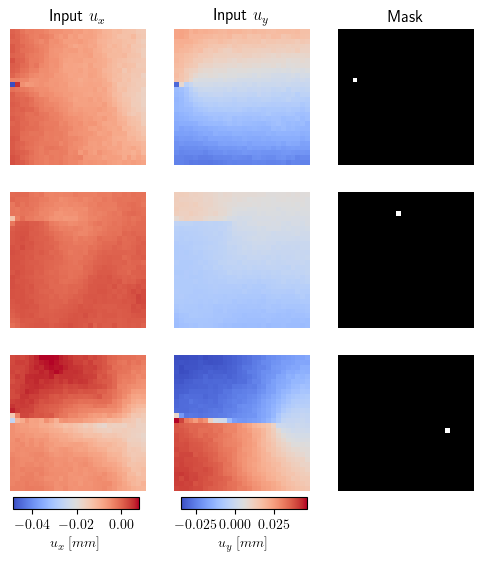

In [7]:
# Select 3 random samples from the segmentation dataset
random_ids = [0, 2000, 4000]
inputs = seg_dataset.images[random_ids]
targets = seg_dataset.targets[random_ids]

fig, axs = plt.subplots(3, 3, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1, 1]})

# Normalize each input type separately across all samples
vmin_x, vmax_x = inputs[:, 0].min(), inputs[:, 0].max()
vmin_y, vmax_y = inputs[:, 1].min(), inputs[:, 1].max()

norm_x = mcolors.Normalize(vmin=vmin_x, vmax=vmax_x)
norm_y = mcolors.Normalize(vmin=vmin_y, vmax=vmax_y)

for i in range(3):
    im_x = axs[i, 0].imshow(inputs[i, 0], cmap='coolwarm', norm=norm_x)
    if i == 0:
        axs[i, 0].set_title(r"Input $u_x$")
    axs[i, 0].axis('off')

    im_y = axs[i, 1].imshow(inputs[i, 1], cmap='coolwarm', norm=norm_y)
    if i == 0:
        axs[i, 1].set_title(r"Input $u_y$")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(targets[i], cmap='gray')
    if i == 0:
        axs[i, 2].set_title("Mask")
    axs[i, 2].axis('off')

# Create separate axes for colorbars at the bottom
cbar_ax_x = fig.add_axes([0.13, 0.08, 0.21, 0.02])  # Colorbar for u_x
cbar_ax_y = fig.add_axes([0.41, 0.08, 0.21, 0.02])  # Colorbar for u_y

# Add colorbars with proper labels
fig.colorbar(im_x, cax=cbar_ax_x, orientation='horizontal', label=r'$u_x\; [mm]$')
fig.colorbar(im_y, cax=cbar_ax_y, orientation='horizontal', label=r'$u_y\; [mm]$')

plt.show()

## Load Dataset for SIF Regression

Now let's load the dataset for stress intensity factor (SIF) regression task.

In [8]:
# Load dataset for SIF regression
sif_dataset = CrackMNIST(split="train", pixels=28, size="S", task="SIF_regression")
print(f"Loaded {len(sif_dataset)} samples for SIF regression")
print(f"Description: {sif_dataset.description}")

Loaded 10048 samples for SIF regression
Description: CrackMNIST is a dataset of 2-channel DIC images (u_x, u_y displacements) as inputs from fatigue crack growth experiments with corresponding stress intensity factors (SIFs) (K_I, K_II, T-Stress) as targets.


## Visualize SIF Values

Display stress intensity factors (K_I, K_II, T-stress) along with displacement fields.

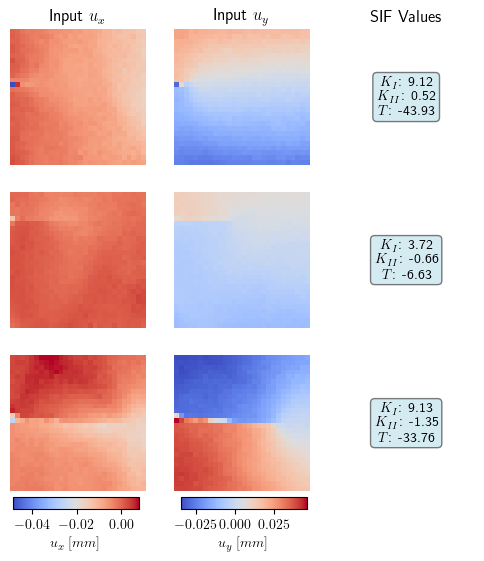

In [9]:
# Select 3 random samples from the SIF regression dataset
random_ids = [0, 2000, 4000]
inputs = sif_dataset.images[random_ids]
sifs = sif_dataset.targets[random_ids]

fig, axs = plt.subplots(3, 3, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1, 1]})

# Normalize each input type separately across all samples
vmin_x, vmax_x = inputs[:, 0].min(), inputs[:, 0].max()
vmin_y, vmax_y = inputs[:, 1].min(), inputs[:, 1].max()

norm_x = mcolors.Normalize(vmin=vmin_x, vmax=vmax_x)
norm_y = mcolors.Normalize(vmin=vmin_y, vmax=vmax_y)

for i in range(3):
    im_x = axs[i, 0].imshow(inputs[i, 0], cmap='coolwarm', norm=norm_x)
    if i == 0:
        axs[i, 0].set_title(r"Input $u_x$")
    axs[i, 0].axis('off')

    im_y = axs[i, 1].imshow(inputs[i, 1], cmap='coolwarm', norm=norm_y)
    if i == 0:
        axs[i, 1].set_title(r"Input $u_y$")
    axs[i, 1].axis('off')

    # Display SIF values as text
    axs[i, 2].axis('off')
    if i == 0:
        axs[i, 2].set_title("SIF Values")
    
    # Extract SIF values (K_I, K_II, T-stress)
    K_I, K_II, T = sifs[i][0], sifs[i][1], sifs[i][2]
    
    # Create text display for SIF values
    sif_text = (f"$K_I$: {K_I:.2f}\n"
                f"$K_{{II}}$: {K_II:.2f}\n"
                f"$T$: {T:.2f}")
    
    axs[i, 2].text(0.5, 0.5, sif_text, 
                   ha='center', va='center', 
                   fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
                   transform=axs[i, 2].transAxes)

# Create separate axes for colorbars at the bottom
cbar_ax_x = fig.add_axes([0.13, 0.08, 0.21, 0.02])  # Colorbar for u_x
cbar_ax_y = fig.add_axes([0.41, 0.08, 0.21, 0.02])  # Colorbar for u_y

# Add colorbars with proper labels
fig.colorbar(im_x, cax=cbar_ax_x, orientation='horizontal', label=r'$u_x\; [mm]$')
fig.colorbar(im_y, cax=cbar_ax_y, orientation='horizontal', label=r'$u_y\; [mm]$')

plt.show()

## Dataset Statistics

Show information about dataset splits and sample counts.

In [10]:
# Load all splits for statistics
train_set = CrackMNIST(split="train", pixels=28, size="S", task="crack_tip_segmentation")
val_set = CrackMNIST(split="val", pixels=28, size="S", task="crack_tip_segmentation")
test_set = CrackMNIST(split="test", pixels=28, size="S", task="crack_tip_segmentation")

print("Dataset Split Statistics:")
print(f"  Train: {len(train_set)} samples")
print(f"  Val:   {len(val_set)} samples")
print(f"  Test:  {len(test_set)} samples")
print(f"  Total: {len(train_set) + len(val_set) + len(test_set)} samples")
print(f"\nImage shape: {train_set[0][0].shape}")
print(f"Mask shape: {train_set[0][1].shape}")

Dataset Split Statistics:
  Train: 10048 samples
  Val:   5944 samples
  Test:  5944 samples
  Total: 21936 samples

Image shape: (2, 28, 28)
Mask shape: (28, 28)


## Sample Metadata and Augmentations

Explore metadata, forces, and augmentations for individual samples.

In [11]:
# Show metadata, force, and augmentation info for a few samples
sample_indices = [0, 100, 500]

print("Sample Metadata Examples:\n")
for idx in sample_indices:
    metadata = seg_dataset.get_metadata(idx)
    force = seg_dataset.get_forces(idx)
    augmentation = seg_dataset.get_augmentations(idx)
    
    print(f"Sample {idx}:")
    print(f"  Experiment: {metadata.get('experiment_name', 'N/A')}")
    print(f"  Material: {metadata.get('material', 'N/A')}")
    print(f"  Thickness: {metadata.get('thickness', 'N/A')} mm")
    print(f"  Force: {force:.2f} N")
    print(f"  Augmentations:")
    print(f"    - Shift: ({augmentation['shift'][0]:.2f}, {augmentation['shift'][1]:.2f}) mm")
    print(f"    - Rotation: {augmentation['rotation']:.2f}°")
    print(f"    - Vertical flip: {augmentation['vertical_flip']}")
    print()

Sample Metadata Examples:

Sample 0:
  Experiment: N/A
  Material: AA2024 (rolled)
  Thickness: N/A mm
  Force: 15001.58 N
  Augmentations:
    - Shift: (1.77, -5.80) mm
    - Rotation: -3.84°
    - Vertical flip: True

Sample 100:
  Experiment: N/A
  Material: AA2024 (rolled)
  Thickness: N/A mm
  Force: 15002.26 N
  Augmentations:
    - Shift: (2.14, 12.30) mm
    - Rotation: 0.30°
    - Vertical flip: False

Sample 500:
  Experiment: N/A
  Material: AA2024 (rolled)
  Thickness: N/A mm
  Force: 8701.71 N
  Augmentations:
    - Shift: (4.13, 18.76) mm
    - Rotation: 9.50°
    - Vertical flip: False

